In [19]:
import warnings

# 모든 경고 메시지 무시
warnings.filterwarnings('ignore')

In [20]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.transforms import transforms
from torch.utils.data.dataloader import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize
import torchvision.transforms as T

from tensorboardX import SummaryWriter
writer = SummaryWriter()

from torchvision import models

# 1. 데이터 불러오기

In [21]:
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(MEAN,STD)
])


transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN,STD)
])


train_datasets = datasets.ImageFolder(root="dataset_celebirity/train", transform=transforms_train)
test_datasets = datasets.ImageFolder(root="dataset_celebirity/test", transform=transforms_test)

In [22]:
train_datasets[0]

(tensor([[[ 1.1700,  1.2043,  1.2043,  ...,  1.6324,  1.6153,  1.0331],
          [ 1.2214,  1.2043,  1.2214,  ...,  1.6324,  1.6324,  1.0331],
          [ 1.2214,  1.2214,  1.2043,  ...,  1.6324,  1.6324,  1.0331],
          ...,
          [ 1.7180,  1.6495,  1.5810,  ..., -0.1314, -0.1828, -0.6623],
          [ 1.6838,  1.6495,  1.5639,  ..., -0.1999, -0.3198, -0.7650],
          [ 1.6667,  1.6153,  1.5297,  ..., -0.3198, -0.4911, -0.7650]],
 
         [[ 1.2381,  1.2731,  1.2731,  ...,  1.6933,  1.6758,  1.0630],
          [ 1.2906,  1.2731,  1.2906,  ...,  1.6933,  1.6933,  1.0630],
          [ 1.2906,  1.2906,  1.2731,  ...,  1.6933,  1.6758,  1.0455],
          ...,
          [ 1.8683,  1.7983,  1.7108,  ..., -0.6527, -0.7227, -1.0553],
          [ 1.8333,  1.7808,  1.6933,  ..., -0.7052, -0.8627, -1.1604],
          [ 1.8158,  1.7633,  1.6583,  ..., -0.7752, -0.9678, -1.1604]],
 
         [[ 0.9494,  0.9842,  0.9668,  ...,  1.4897,  1.4722,  0.9494],
          [ 1.0017,  0.9842,

## 데이터 확인하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].


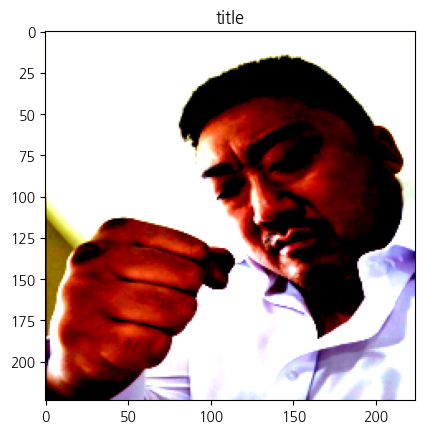

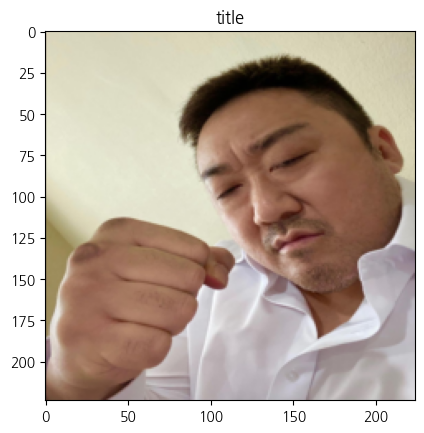

정답: 마동석


In [23]:
from tools.image_util import denormalize, view_img

view_img(train_datasets[0][0])
view_img(denormalize(train_datasets[0][0], MEAN, STD))
print(f'정답: {train_datasets.classes[train_datasets[0][1]]}')

# 2. 데이터 배치사이즈로 분리하기

In [24]:
train_dataLoader = DataLoader(train_datasets, batch_size=4, shuffle=True) 
test_dataLoader = DataLoader(test_datasets, batch_size=4) 

## 데이터 확인하기

torch.Size([3, 224, 224])
tensor(1)


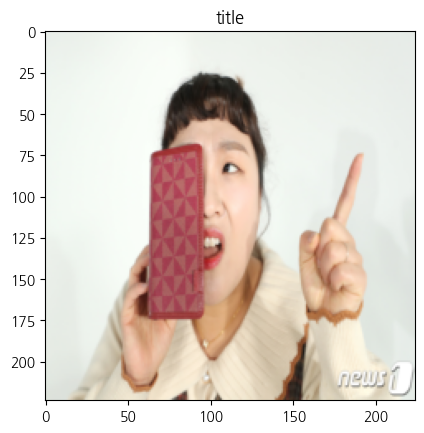

정답: 이수지


In [25]:
data, label = next(iter(train_dataLoader))
print(data[0].shape)
print(label[0])

view_img(denormalize(data[0], MEAN, STD))
print(f'정답: {train_datasets.classes[label[0]]}')

In [26]:
train_datasets.classes

['마동석', '이수지', '카리나']

## 데이터 그리드로 확인하기

tensor([2, 0, 0, 0])


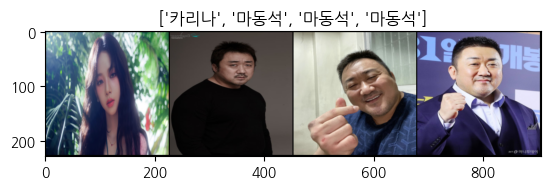

In [27]:
import matplotlib.pyplot as plt
from tools.image_util import view_img

images, labels = next(iter(train_dataLoader))
images_data = torchvision.utils.make_grid([denormalize(image, MEAN, STD) for image in images])

print(labels)
view_img(images_data, [train_datasets.classes[label] for label in list(labels.tolist())])

# 3. 모델 정의하기/준비하기

In [28]:
model = models.resnet34(pretrained = True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=3, bias=True)

# 4. 모델 학습하기

In [30]:
optim = Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

writer = SummaryWriter()
step = 0

for epoch in range(epochs):
    for data, labels in train_dataLoader:

        optim.zero_grad()

        preds = model(data.to(device))

        loss = criterion(preds, labels.to(device))

        loss.backward()
        optim.step()

        writer.add_scalar("Loss/train", loss.item(), step)
        step += 1
        
    print(f"{epoch + 1} loss : {loss.item()}")

1 loss : 0.7469334602355957
2 loss : 0.6959285736083984
3 loss : 0.7232708930969238
4 loss : 0.4626597464084625
5 loss : 0.7089278101921082
6 loss : 0.6664958596229553
7 loss : 0.35733678936958313
8 loss : 0.33532989025115967
9 loss : 1.134725570678711
10 loss : 0.4647434949874878
11 loss : 0.523444414138794
12 loss : 0.44723477959632874
13 loss : 0.10784170031547546
14 loss : 0.37772026658058167
15 loss : 0.43924203515052795
16 loss : 0.6821799278259277
17 loss : 0.36909928917884827
18 loss : 0.08975579589605331
19 loss : 0.27040013670921326
20 loss : 0.5676202178001404
21 loss : 0.13416098058223724
22 loss : 0.1636286824941635
23 loss : 0.23216642439365387
24 loss : 0.17674289643764496
25 loss : 0.06111961975693703
26 loss : 0.3587304353713989
27 loss : 0.4006946384906769
28 loss : 0.11877694725990295
29 loss : 0.2428031712770462
30 loss : 0.17539703845977783
31 loss : 0.5581957697868347
32 loss : 0.6295795440673828
33 loss : 0.6393499970436096
34 loss : 0.048983946442604065
35 loss 

# 5. 모델 저장하기

In [ ]:
torch.save(model.state_dict(), 'models/celebrity_image_resnet34_model.pth') # 모델의 가중치만 저장

In [ ]:
torch.save(model, 'models/celebrity_image_resnet34_model_all.pth') # 모델을 통으로 저장

# 6. 모델 평가하기

예측결과 : tensor([0, 0, 0, 0], device='cuda:0'), 정답: tensor([0, 0, 0, 0])


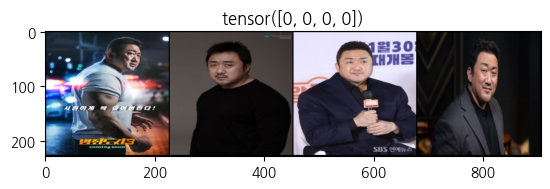

예측결과 : tensor([0, 0, 0, 0], device='cuda:0'), 정답: tensor([0, 0, 0, 0])


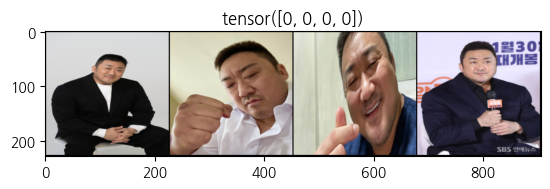

예측결과 : tensor([0, 0, 1, 1], device='cuda:0'), 정답: tensor([0, 0, 1, 1])


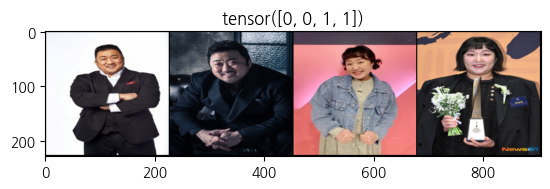

예측결과 : tensor([1, 0, 1, 1], device='cuda:0'), 정답: tensor([1, 1, 1, 1])


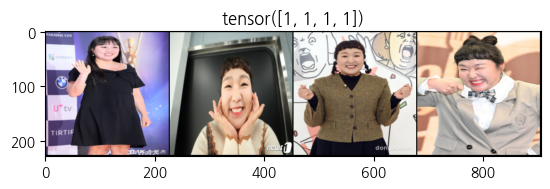

예측결과 : tensor([0, 1, 1, 2], device='cuda:0'), 정답: tensor([1, 1, 1, 1])


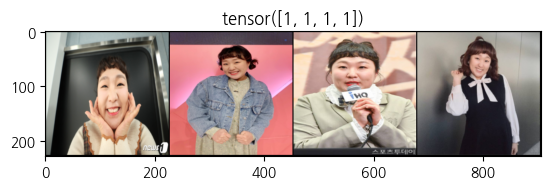

예측결과 : tensor([2, 2, 2, 2], device='cuda:0'), 정답: tensor([2, 2, 2, 2])


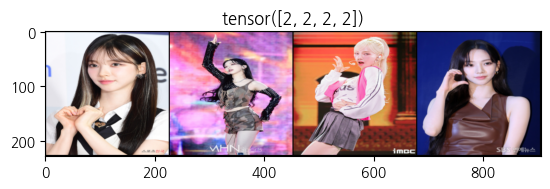

예측결과 : tensor([2, 2, 2, 1], device='cuda:0'), 정답: tensor([2, 2, 2, 2])


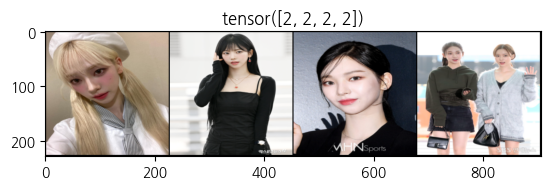

예측결과 : tensor([2, 2], device='cuda:0'), 정답: tensor([2, 2])


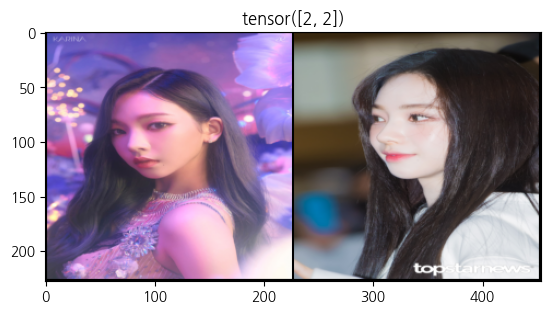

정답/전체:  26/30
정확도: 86.66666666666667%


In [52]:
model.eval()
with torch.no_grad():
    total_correct = 0
    for data, label in test_dataLoader:
        preds = model(data.to(device)) # [0.1 , 0.4, 0.01]

        _, pred = torch.max(preds, dim=1)
        
        total_correct += (pred==label.to(device).data).sum().item()

        print(f'예측결과 : {pred}, 정답: {label}')
        
        images_data = torchvision.utils.make_grid([denormalize(image, MEAN, STD) for image in data])
        view_img(images_data, label)

print(f'정답/전체:  {total_correct}/{len(test_dataLoader.dataset)}')
print(f'정확도: {total_correct / len(test_dataLoader.dataset) * 100}%')

# 7. 모델 사용

In [54]:
from PIL import Image

image = Image.open('images/이수지_테스트.jpg')
image = transforms_test(image).unsqueeze(0).to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [64]:
preds = model(image)
pred = torch.max(preds, dim=1)[1]
test_datasets.classes[pred]

'마동석'